In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

#### 행정경계

In [2]:
dj_b = pd.read_csv("./대전시_행정경계.csv")
dj_b["geometry"] = dj_b["geometry"].apply(wkt.loads)
dj_b = gpd.GeoDataFrame(dj_b, geometry="geometry")
dj_pol = dj_b.dissolve(by=None)
dj_geo_dic = dict(zip(dj_b['ADM_CD'], dj_b['geometry']))

#### 격자단위(대전)

In [3]:
# 디렉토리 경로
shp_dir1 = "./격자단위/_grid_border_grid_2023_grid_다마_grid_다마"
shp_dir2 = "./격자단위/_grid_border_grid_2023_grid_다바_grid_다바"
shp_dir3 = "./격자단위/_grid_border_grid_2023_grid_라바_grid_라바"

# 디렉토리 내 .shp 파일 찾기
shp_files1 = [f for f in os.listdir(shp_dir1) if f.endswith('.shp')]
shp_files2 = [f for f in os.listdir(shp_dir2) if f.endswith('.shp')]
shp_files3 = [f for f in os.listdir(shp_dir3) if f.endswith('.shp')]

# 첫 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir1, shp_files1[0])
gdf1 = gpd.read_file(shp_path)
gdf1 = gdf1.to_crs(epsg=4326)

# 두 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir2, shp_files2[0])
gdf2 = gpd.read_file(shp_path)
gdf2 = gdf2.to_crs(epsg=4326)

# 세 번째 .shp 파일 읽기
shp_path = os.path.join(shp_dir3, shp_files3[0])
gdf3 = gpd.read_file(shp_path)
gdf3 = gdf3.to_crs(epsg=4326)

# 폴리곤 통합
gdf_con = pd.concat([gdf1, gdf2, gdf3]).reset_index(drop=True)
gdf_con.rename(columns={'GRID_1K_CD' : 'grid_cd'}, inplace=True)

# 대전 격자로만 필터링
dj_grid = gdf_con[gdf_con.intersects(dj_pol.unary_union)]

dj_grid_dic = dict(zip(dj_grid['grid_cd'], dj_grid['geometry']))

In [ ]:
# dj_grid.to_csv("대전시_격자.csv", index=False)

#### 격자단위(탄소배출)

In [4]:
co2 = pd.read_csv("./격자단위/탄소배출 총괄_전체_격자_1km_2022.csv", encoding='cp949')
dj_co2 = co2[co2['grid_cd'].isin(dj_grid['grid_cd'].tolist())]
dj_co2['geometry'] = dj_co2['grid_cd'].map(dj_grid_dic)

dj_co2 # 이 데이터 프레임에 격자통계 추가할 것

C:\Users\user\AppData\Local\Temp\ipykernel_19952\944018120.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,grid_cd,emissions,geometry
136,라바0013,62.71,POLYGON ((127.50000000000001 36.31434675521236...
144,라바0014,65.21,POLYGON ((127.50000000000001 36.32336221829146...
151,라바0015,1240.97,POLYGON ((127.50000000000001 36.33237766774219...
159,라바0016,922.49,POLYGON ((127.50000000000001 36.34139310356320...
167,라바0017,7123.83,POLYGON ((127.50000000000001 36.35040852575323...
...,...,...,...
105974,다바9924,27.36,POLYGON ((127.48884610188327 36.41351557840409...
105984,다바9925,0.00,POLYGON ((127.48884481266187 36.42253089132852...
105994,다바9926,0.00,POLYGON ((127.48884352286736 36.43154619061015...
106004,다바9927,0.00,POLYGON ((127.48884223249948 36.44056147624773...


#### 인구

In [5]:
grid1 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_인구_다마_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'age', 'cnt'])
grid2 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_인구_다바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'age', 'cnt'])
grid3 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_인구_라바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'age', 'cnt'])

# 데이터 합치기
grid_con1 = pd.concat([grid1, grid2, grid3], ignore_index=True)
grid_con1 = grid_con1[grid_con1['age'] == "to_in_001"]
pop_dic = dict(zip(grid_con1['grid_cd'], grid_con1['cnt']))
dj_co2['pop'] = dj_co2['grid_cd'].map(pop_dic).fillna(0)

C:\Users\user\AppData\Local\Temp\ipykernel_19952\2110463865.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 가구(hh=household)

In [6]:
grid1 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_가구_다마_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'hh', 'cnt'])
grid2 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_가구_다바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'hh', 'cnt'])
grid3 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_가구_라바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'hh', 'cnt'])

# 데이터 합치기
grid_con1 = pd.concat([grid1, grid2, grid3], ignore_index=True)
grid_con1 = grid_con1[grid_con1['hh'] == "to_ga_001"]
household_dic = dict(zip(grid_con1['grid_cd'], grid_con1['cnt']))
dj_co2['household'] = dj_co2['grid_cd'].map(household_dic).fillna(0)

C:\Users\user\AppData\Local\Temp\ipykernel_19952\466356201.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 산업기반 도시화 지수(산업체 및 종사자)

In [7]:
business_dict = {
    "cp_bnu_001": "농업, 임업 및 어업",
    "cp_bnu_002": "광업",
    "cp_bnu_003": "제조업",
    "cp_bnu_004": "전기, 가스, 증기 및 공기조절 공급업",
    "cp_bnu_005": "수도, 하수 및 폐기물처리, 원료 재생업",
    "cp_bnu_006": "건설업",
    "cp_bnu_007": "도매 및 소매업",
    "cp_bnu_008": "운수 및 창고업",
    "cp_bnu_009": "숙박 및 음식점업",
    "cp_bnu_010": "정보통신업",
    "cp_bnu_011": "금융 및 보험업",
    "cp_bnu_012": "부동산업",
    "cp_bnu_013": "전문, 과학 및 기술 서비스업",
    "cp_bnu_014": "사업시설관리, 사업지원 및 임대 서비스업",
    "cp_bnu_015": "공공행정, 국방 및 사회보장 행정",
    "cp_bnu_016": "교육 서비스업",
    "cp_bnu_017": "보건업 및 사회복지 서비스업",
    "cp_bnu_018": "예술, 스포츠 및 여가관련 서비스업",
    "cp_bnu_019": "협회 및 단체, 수리 및 기타 개인 서비스업"
}

business_worker_dict = {
    "cp_bem_001": "농업, 임업 및 어업",
    "cp_bem_002": "광업",
    "cp_bem_003": "제조업",
    "cp_bem_004": "전기, 가스, 증기 및 공기조절 공급업",
    "cp_bem_005": "수도, 하수 및 폐기물처리, 원료 재생업",
    "cp_bem_006": "건설업",
    "cp_bem_007": "도매 및 소매업",
    "cp_bem_008": "운수 및 창고업",
    "cp_bem_009": "숙박 및 음식점업",
    "cp_bem_010": "정보통신업",
    "cp_bem_011": "금융 및 보험업",
    "cp_bem_012": "부동산업",
    "cp_bem_013": "전문, 과학 및 기술 서비스업",
    "cp_bem_014": "사업시설관리, 사업지원 및 임대 서비스업",
    "cp_bem_015": "공공행정, 국방 및 사회보장 행정",
    "cp_bem_016": "교육 서비스업",
    "cp_bem_017": "보건업 및 사회복지 서비스업",
    "cp_bem_018": "예술, 스포츠 및 여가관련 서비스업",
    "cp_bem_019": "협회 및 단체, 수리 및 기타 개인 서비스업"
}

grid1 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_사업체_다마_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bn_cd', 'cnt'])
grid2 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_사업체_다바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bn_cd', 'cnt'])
grid3 = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_사업체_라바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bn_cd', 'cnt'])

grid1_w = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_종사자_다마_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bw_cd', 'emp_cnt'])
grid2_w = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_종사자_다바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bw_cd', 'emp_cnt'])
grid3_w = pd.read_csv('./격자단위/_census_reqdoc_1740904802861/2022년_종사자_라바_1K.txt', sep="^", header=None, names=['year', 'grid_cd', 'bw_cd', 'emp_cnt'])

# 데이터 합치기(사업체)
grid_con1 = pd.concat([grid1, grid2, grid3], ignore_index=True)
grid_con1['bn_nm'] = grid_con1['bn_cd'].map(business_dict)
grid_con1 = grid_con1.dropna()

# 데이터 합치기(종사자)
grid_con1_w = pd.concat([grid1_w, grid2_w, grid3_w], ignore_index=True)
grid_con1_w['bn_nm'] = grid_con1_w['bw_cd'].map(business_worker_dict)
grid_con1_w = grid_con1_w.dropna()

# 온실가스 배출과 관련된 산업 리스트
high_emission_sectors = [
    '제조업', '건설업', '운수 및 창고업',
    '전기, 가스, 증기 및 공기조절 공급업',
    '수도, 하수 및 폐기물처리, 원료 재생업'
]

# 행정동별 전체 종사자 수 계산 (cnt 합계)
total_counts  = grid_con1.groupby("grid_cd")["cnt"].sum().reset_index()
total_counts .columns = ["grid_cd", "total_bn"]

# 종사자 수 데이터 (dj_emp 활용)
total_emp_counts = grid_con1_w.groupby("grid_cd")["emp_cnt"].sum().reset_index()
total_emp_counts.columns = ["grid_cd", "total_emp"]

# 온실가스 배출 관련 산업의 사업체 수 계산 (cnt 합계)
high_emission_counts = grid_con1[grid_con1["bn_nm"].isin(high_emission_sectors)]
high_emission_counts = high_emission_counts.groupby("grid_cd")["cnt"].sum().reset_index()
high_emission_counts.columns = ["grid_cd", "high_emission_bn"]

high_emission_emp_counts = grid_con1_w[grid_con1_w["bn_nm"].isin(high_emission_sectors)]
high_emission_emp_counts = high_emission_emp_counts.groupby("grid_cd")["emp_cnt"].sum().reset_index()
high_emission_emp_counts.columns = ["grid_cd", "high_emission_emp"]

# 데이터 병합 (온실가스 관련 산업과 전체 사업체)
urbanization_emission_df = total_counts.merge(high_emission_counts, on="grid_cd", how="left").fillna(0)
urbanization_emission_df = urbanization_emission_df.merge(total_emp_counts, on="grid_cd", how="left").fillna(0)
urbanization_emission_df = urbanization_emission_df.merge(high_emission_emp_counts, on="grid_cd", how="left").fillna(0)

# 종사자 수를 반영한 산업 기반 도시화 지수 계산
urbanization_emission_df["urbanization_index"] = (
    (urbanization_emission_df["high_emission_bn"] * urbanization_emission_df["high_emission_emp"]) /
    (urbanization_emission_df["total_bn"] * urbanization_emission_df["total_emp"])
)

In [8]:
# 로지스틱 변환 설정값
k = 10
c = 0.5  # 중심 보정값 (데이터에 따라 조정 가능)
alpha = 0.5  # UI와 사업체 개수 가중치 비율

# 최소 사업체 개수 필터링
# urbanization_emission_df = urbanization_emission_df[urbanization_emission_df["total_bn"] >= min_business_threshold]

# 로지스틱 변환 적용 (극단값 방지)
urbanization_emission_df["urbanization_emission_index_adj"] = 1 / (1 + np.exp(-k * (urbanization_emission_df["urbanization_index"] - c)))

# Min-Max Scaling 가중치 적용 (사업체 수 기반)
min_businesses = urbanization_emission_df["total_bn"].min()
max_businesses = urbanization_emission_df["total_bn"].max()
urbanization_emission_df["weight"] = (urbanization_emission_df["total_bn"] - min_businesses) / (max_businesses - min_businesses)

# 최종 도시화 지수 계산 (α 비율 조정)
urbanization_emission_df["urbanization_emission_index_final"] = (
    (1 - alpha) * urbanization_emission_df["urbanization_emission_index_adj"] +
    alpha * urbanization_emission_df["weight"]
)
urbanization_emission_df["urbanization_emission_index_final"] = urbanization_emission_df["urbanization_emission_index_final"].fillna(0)
urbanization_dic = dict(zip(urbanization_emission_df['grid_cd'], urbanization_emission_df['urbanization_emission_index_final']))
dj_co2['urbanization_index'] = dj_co2['grid_cd'].map(urbanization_dic).fillna(0)

C:\Users\user\AppData\Local\Temp\ipykernel_19952\3658351781.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
dj_co2['geometry'] = dj_co2['geometry'].astype(str)

# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)

# 도시 행정경계
map.add_data(data=dj_co2, name="대전시_격자통계")

# 도시 행정경계
map.add_data(data=dj_b, name="대전시")

# 맵 출력 및 상세설정
map

C:\Users\user\AppData\Local\Temp\ipykernel_17072\1217818392.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'대전시_격자통계': {'index': [136, 144, 151, 159, 167, 175, 184, 193, 203, 212, 222, 259, 268, 1174, 1…

In [12]:
map.save_to_html(file_name="대전시_격자통계.html")

Map saved to 대전시_격자통계.html!


In [15]:
dj_co2.to_csv('dj_co2.csv', index=False)

📊 인구(pop)와 온실가스 배출량(emissions)의 피어슨 상관계수: 0.6077


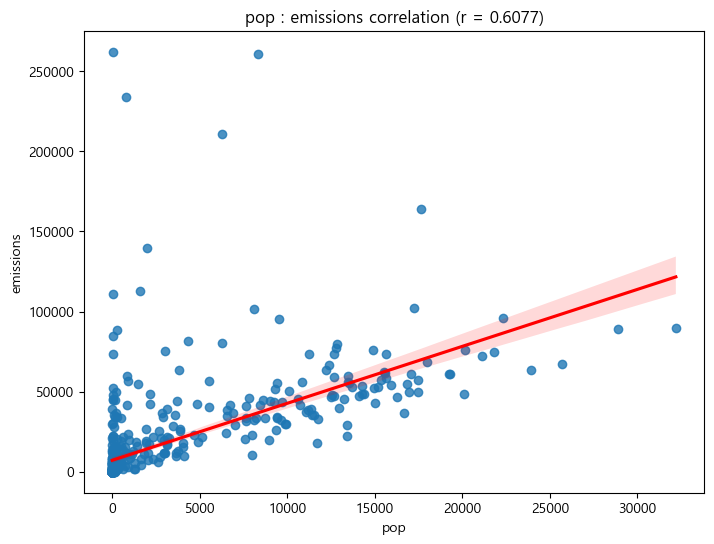

In [18]:
import seaborn as sns

# 상관계수 계산
correlation = dj_co2["pop"].corr(dj_co2["emissions"], method="pearson")

# 결과 출력
print(f"📊 인구(pop)와 온실가스 배출량(emissions)의 피어슨 상관계수: {correlation:.4f}")

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=dj_co2["pop"], y=dj_co2["emissions"], line_kws={"color": "red"})
plt.xlabel("pop")
plt.ylabel("emissions")
plt.title(f"pop : emissions correlation (r = {correlation:.4f})")
plt.show()

📊 가구수수(household)와 온실가스 배출량(emissions)의 피어슨 상관계수: 0.6174


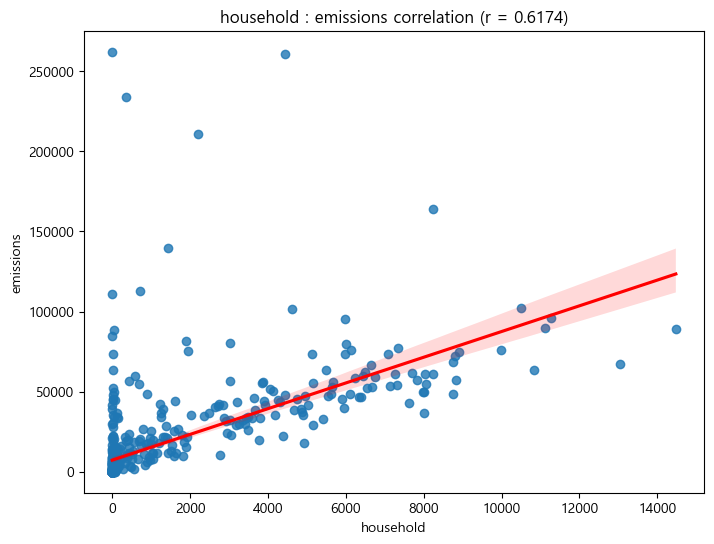

In [ ]:
# 상관계수 계산
correlation = dj_co2["household"].corr(dj_co2["emissions"], method="pearson")

# 결과 출력
print(f"📊 가구수(household)와 온실가스 배출량(emissions)의 피어슨 상관계수: {correlation:.4f}")

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=dj_co2["household"], y=dj_co2["emissions"], line_kws={"color": "red"})
plt.xlabel("household")
plt.ylabel("emissions")
plt.title(f"household : emissions correlation (r = {correlation:.4f})")
plt.show()

📊 산업기반 도시화지수(urbanization_index)와 온실가스 배출량(emissions)의 피어슨 상관계수: 0.4668


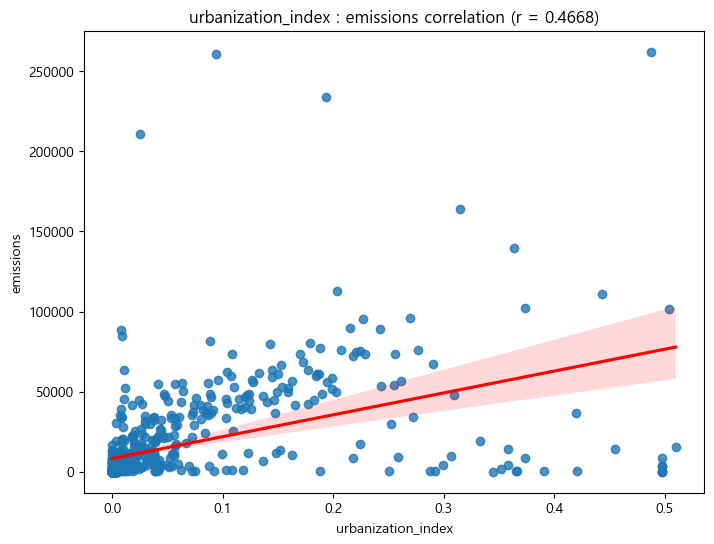

In [22]:
# 상관계수 계산
correlation = dj_co2["urbanization_index"].corr(dj_co2["emissions"], method="pearson")

# 결과 출력
print(f"📊 산업기반 도시화지수(urbanization_index)와 온실가스 배출량(emissions)의 피어슨 상관계수: {correlation:.4f}")

# 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=dj_co2["urbanization_index"], y=dj_co2["emissions"], line_kws={"color": "red"})
plt.xlabel("urbanization_index")
plt.ylabel("emissions")
plt.title(f"urbanization_index : emissions correlation (r = {correlation:.4f})")
plt.show()